# Differential abundance analysis

In [5]:
figDir = '~/Hyphosphere/data/3Exp/figures'

work_dir = '~/Hyphosphere/data/3Exp/DESeq'

# phyloseq - full object without tree (includes archaea)
physeq_file = '~/Hyphosphere/data/3Exp/phyloseq/3Exp_phyloseq_thresh_woTree_experimental_woContam.rds'

In [42]:
library(RColorBrewer)
library(vegan)
library(tidyr)
library(dplyr)
library(reshape2)
library(phyloseq)
library(gridExtra)
library(ggplot2)
library(DESeq2)
library(pheatmap)

Warning message:
“package ‘pheatmap’ was built under R version 3.6.1”

In [2]:
theme_pub = function (base_size = 11, base_family = "Arial") 
{
    theme_grey(base_size = base_size, base_family = base_family) %+replace% 
        theme(
            axis.line.x = element_line(size = .5),
            axis.line.y = element_line(size = .5),
            panel.background = element_rect(fill = "white", colour = NA), 
            panel.border = element_rect(fill = NA, color = "black", size = .5), 
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            strip.background = element_rect(fill = "grey85", 
                colour = "grey20"), 
            legend.key = element_rect(fill = "white", 
                colour = NA), complete = TRUE)
    }

In [191]:
psCHBS = readRDS(physeq_file) %>% subset_taxa(., !is.na(Phylum)) %>%
    # remove non-experimental controls
    
    subset_samples(., SampleType %in% c("BS","CH") & Experiment == 3 & !Sample == "T0R1") %>%
     filter_taxa(., function(x) max(x) > 0, TRUE)
     # re-normalize after subsetting taxa
    #transform_sample_counts(., function(x) x/sum(x))
sample_data(ps)$Rep = as.factor(sample_data(ps)$Rep)

psCHBS


                                  


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 10686 taxa and 59 samples ]
sample_data() Sample Data:       [ 59 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 10686 taxa by 6 taxonomic ranks ]

In [170]:
taxa = tax_table(ps) %>% as.data.frame() %>% mutate(ASV = row.names(.))
head(taxa)

Kingdom,Phylum,Class,Order,Family,Genus,ASV
Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Micrococcaceae,Pseudarthrobacter,ASV5
Bacteria,Proteobacteria,Gammaproteobacteria,Cellvibrionales,Cellvibrionaceae,Cellvibrio,ASV6
Bacteria,Proteobacteria,Alphaproteobacteria,Caulobacterales,Caulobacteraceae,Asticcacaulis,ASV8
Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Luteimonas,ASV13
Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA,ASV14
Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,NA,ASV15


In [171]:
sample_data(ps)$SoilxFungus = paste(sample_data(ps)$Soil,"-",sample_data(ps)$Fungus, sep = "")
sample_data(ps) %>% head()


,Sample,Experiment,Plant,Fungus,Soil,SampleType,Treatment,TimePoint,DAI,Rep,Concentration_ng.ul,SoilxFungus
1.1CH,1.1CH,3,1.1,Gv,Lansing,CH,HN,1,14,1,0.325,Lansing-Gv
1.1CS,1.1CS,3,1.1,Gv,Lansing,CS,HN,1,14,1,2.116,Lansing-Gv
1.2CH,1.2CH,3,1.2,Gv,Lansing,CH,HN,2,24,1,0.170,Lansing-Gv
1.2CS,1.2CS,3,1.2,Gv,Lansing,CS,HN,2,24,1,0.677,Lansing-Gv
1.3CH,1.3CH,3,1.3,Gv,Lansing,CH,HN,3,35,1,0.160,Lansing-Gv
1.3CS,1.3CS,3,1.3,Gv,Lansing,CS,HN,3,35,1,4.542,Lansing-Gv



## read back in log2foldchange files

In [12]:
readfile = file.path(work_dir, 'dfl2fc-Exp3.txt')
df.l2fc.Exp3 = read.table(readfile, header = TRUE, sep= '\t')

readfile = file.path(work_dir, 'dfl2fc-Exp3-time.txt')
df.l2fc.Exp3.time = read.table(readfile, header = TRUE, sep= '\t')

head(df.l2fc.Exp3.time)

baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,OTU,Subset,SampleType,Term,Contrast,Kingdom,Phylum,Class,Order,Family,Genus,Experiment
306.5828338,-0.69217257,0.2280148,-3.03564798,0.002400194,0.07209155,ASV5,Lansing-Gv,BS,TimePoint,24_14,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Micrococcaceae,Pseudarthrobacter,3
15.0782975,-2.65773367,1.4491982,-1.83393392,0.066663804,0.38138952,ASV6,Lansing-Gv,BS,TimePoint,24_14,Bacteria,Proteobacteria,Gammaproteobacteria,Cellvibrionales,Cellvibrionaceae,Cellvibrio,3
2.3733196,1.63296509,3.0480366,0.53574326,0.592135998,NA,ASV8,Lansing-Gv,BS,TimePoint,24_14,Bacteria,Proteobacteria,Alphaproteobacteria,Caulobacterales,Caulobacteraceae,Asticcacaulis,3
0.0000000,NA,NA,NA,NA,NA,ASV13,Lansing-Gv,BS,TimePoint,24_14,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Luteimonas,3
0.9592065,-0.06318923,3.0779549,-0.02052961,0.983620888,NA,ASV14,Lansing-Gv,BS,TimePoint,24_14,Bacteria,Proteobacteria,Deltaproteobacteria,Myxococcales,Sandaracinaceae,NA,3
16.5732171,-8.02811147,2.9650833,-2.70755002,0.006778186,0.14089255,ASV15,Lansing-Gv,BS,TimePoint,24_14,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,NA,3


# Which ASVs are time specific

# Which Hyphal ASVs change with time

In [ ]:
HASVs = df.l2fc.Exp3 %>%
    filter(Contrast == "CH_CS" & padj < 0.05 & log2FoldChange > 0 & Subset == "Lansing-Gv") %>%
    .$OTU %>%
    unique()
length(HASVs)

df.THASVs = df.l2fc.Exp3.time %>%
    filter(SampleType == "CH" & padj < 0.05 & OTU %in% HASVs) %>%
     .$OTU %>%
    unique() %>% 
    as.character()
length(df.THASVs)

# Heat map of variance stabilized counts

## CH and BS

In [179]:

sample_data(psCHBS)$Rep = factor(sample_data(ps)$Rep)
sample_data(psCHBS)$DAI = factor(sample_data(ps)$DAI)

dds = phyloseq_to_deseq2(psCHBS, ~ Rep + SampleType + DAI + SampleType:DAI)

#save variance stabilized counts
vst = varianceStabilizingTransformation(dds, blind=FALSE)


outfile = file.path(work_dir, 'DESeqObject_Exp2CHBS_vsttrans.rds')

saveRDS(vst, file = outfile)

converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”

### CH CS

In [198]:
psCHCS = readRDS(physeq_file) %>% subset_taxa(., !is.na(Phylum)) %>%
    # remove non-experimental controls
    
    subset_samples(., SampleType %in% c("CS","CH") & Experiment == 3 & !Sample == "T0R1") %>%
     filter_taxa(., function(x) max(x) > 0, TRUE)
     # re-normalize after subsetting taxa
    #transform_sample_counts(., function(x) x/sum(x))
sample_data(psCHBS)$Rep = as.factor(sample_data(psCHBS)$Rep)

psCHCS


                                  


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 10717 taxa and 59 samples ]
sample_data() Sample Data:       [ 59 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 10717 taxa by 6 taxonomic ranks ]

In [187]:
sample_data(ps)$Rep = factor(sample_data(ps)$Rep)
sample_data(ps)$DAI = factor(sample_data(ps)$DAI)

dds = phyloseq_to_deseq2(ps, ~ Rep + SampleType + DAI + SampleType:DAI)

#save variance stabilized counts
vst = varianceStabilizingTransformation(dds, blind=FALSE)


outfile = file.path(work_dir, 'DESeqObject_Exp2CHCS_vsttrans.rds')

saveRDS(vst, file = outfile)

converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”

# Checkpoint read vst transformed deseq object
## CHBS

In [195]:
vstCHBS = readRDS(file.path(work_dir, 'DESeqObject_Exp2CHBS_vsttrans.rds'))

Warning message in class(x) <- c(subclass, tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”Warning message:
“Column `ASV` joining factor and character vector, coercing into character vector”Warning message:
“Column `ASV` joining factor and character vector, coercing into character vector”Warning message in class(x) <- c(subclass, tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

png 
  2

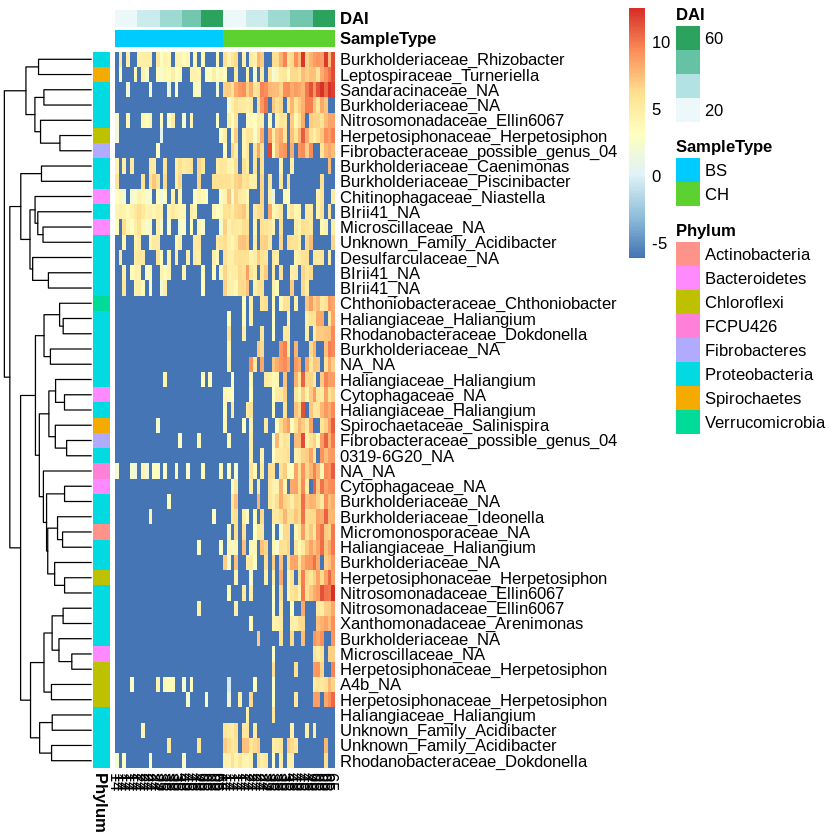

In [196]:
# get list to arrange columns of matrix
col.order = sample_data(psCHBS) %>% as.data.frame() %>% arrange(SampleType,DAI) %>% .$Sample %>% as.character()

# filter to ASVs of interest and arrange according to taxonomy
row.order = taxa %>% 
    filter(ASV %in% df.THASVs) %>% 
    arrange(Kingdom, Phylum, Class, Order, Family, Genus) %>%
    .$ASV %>% as.character()


# convert variance stabilized counts to matrix
mat = assay(vstCHBS[row.order,col.order])
#mat = mat - rowMeans(mat)
#head(mat)

#Create dataframe for row annotations 
PhylumAnno = rownames(mat) %>% 
    as.data.frame() %>% 
    'colnames<-'('ASV') %>%
    left_join(., taxa, by = "ASV") %>% 
    'rownames<-'(.$ASV) %>% 
    select(Phylum)

# Create dataframe for row labels
LabelAnno = rownames(mat) %>% 
    as.data.frame() %>% 
    'colnames<-'('ASV') %>%
    left_join(., taxa, by = "ASV") %>% 
    'rownames<-'(.$ASV) %>% 
    unite_(col='Label', c("Family","Genus"), sep="_", remove=FALSE) %>%
    select(Label)

#Create dataframe for row annotations based on phylum

#create annotation dataframe
anno = sample_data(psCHBS) %>% arrange(SampleType, DAI) %>% .[,c("SampleType","DAI")] %>% as.data.frame()
#colnames(anno) = 'DAI'
rownames(anno) = colnames(mat)

#anno <- as.data.frame(colData(vst)[, 'DAI'])
ph = pheatmap(mat, cluster_cols = F, annotation_col = anno, annotation_row = PhylumAnno, 
         labels_row = LabelAnno$Label, labels_col = anno$DAI)

pdf(file = file.path(figDir,'HeatMap_Time_BSCH.pdf'), width = 6.89, height = 7)
ph
dev.off()
#pheatmap(mat, annotation_col = anno)
rm(vstCHBS)

In [176]:
head(anno)

,DAI,NA
1.1CH,CH,14
2.1CH,CH,14
3.1CH,CH,14
4.1CH,CH,14
5.1CH,CH,14
6.1CH,CH,14


## CH and CS

Warning message in class(x) <- c(subclass, tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”Warning message:
“Column `ASV` joining factor and character vector, coercing into character vector”Warning message:
“Column `ASV` joining factor and character vector, coercing into character vector”Warning message in class(x) <- c(subclass, tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

png 
  2

Warning message in rm(vstCHBS):
“object 'vstCHBS' not found”

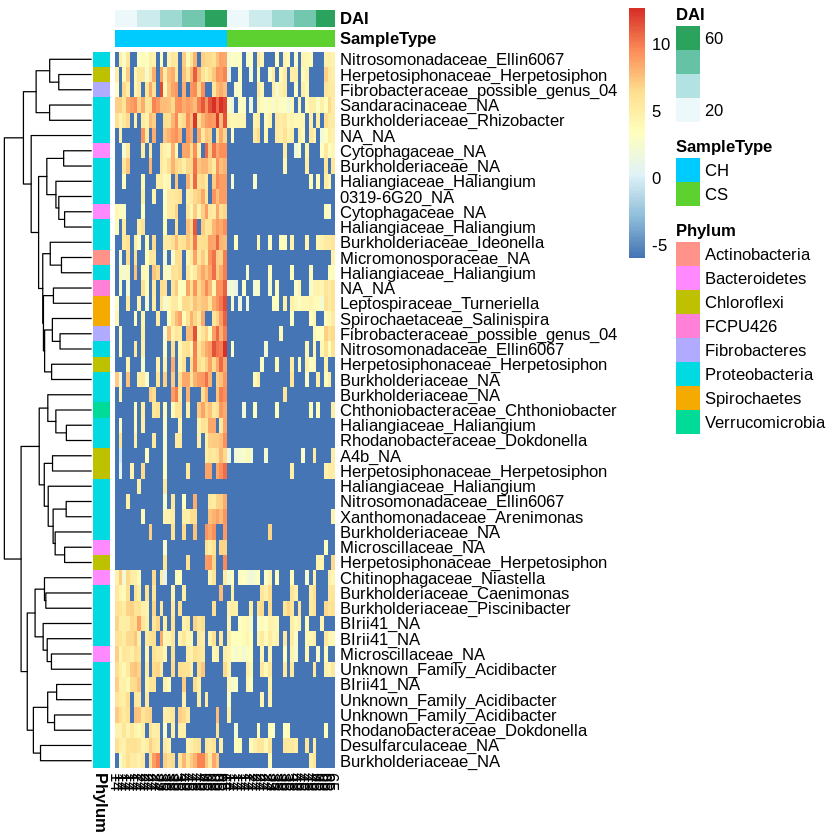

In [200]:
vstCHCS = readRDS(file.path(work_dir, 'DESeqObject_Exp2CHCS_vsttrans.rds'))

# get list to arrange columns of matrix
col.order = sample_data(psCHCS) %>% as.data.frame() %>% arrange(SampleType,DAI) %>% .$Sample %>% as.character()

# filter to ASVs of interest and arrange according to taxonomy
row.order = taxa %>% 
    filter(ASV %in% df.THASVs) %>% 
    arrange(Kingdom, Phylum, Class, Order, Family, Genus) %>%
    .$ASV %>% as.character()


# convert variance stabilized counts to matrix
mat = assay(vstCHCS[row.order,col.order])
#mat = mat - rowMeans(mat)
#head(mat)

#Create dataframe for row annotations 
PhylumAnno = rownames(mat) %>% 
    as.data.frame() %>% 
    'colnames<-'('ASV') %>%
    left_join(., taxa, by = "ASV") %>% 
    'rownames<-'(.$ASV) %>% 
    select(Phylum)

# Create dataframe for row labels
LabelAnno = rownames(mat) %>% 
    as.data.frame() %>% 
    'colnames<-'('ASV') %>%
    left_join(., taxa, by = "ASV") %>% 
    'rownames<-'(.$ASV) %>% 
    unite_(col='Label', c("Family","Genus"), sep="_", remove=FALSE) %>%
    select(Label)

#Create dataframe for row annotations based on phylum

#create annotation dataframe
anno = sample_data(psCHCS) %>% arrange(SampleType, DAI) %>% .[,c("SampleType","DAI")] %>% as.data.frame()
#colnames(anno) = 'DAI'
rownames(anno) = colnames(mat)

#anno <- as.data.frame(colData(vst)[, 'DAI'])
ph = pheatmap(mat, cluster_cols = F, annotation_col = anno, annotation_row = PhylumAnno, 
         labels_row = LabelAnno$Label, labels_col = anno$DAI)

pdf(file = file.path(figDir,'HeatMap_Time_CSCH.pdf'), width = 6.89, height = 7)
ph
dev.off()
#pheatmap(mat, annotation_col = anno)
rm(vstCHBS)